In [1]:
!pip install matplotlib

In [2]:
import os, zipfile
zip_file_name = 'captcha_images_8k.zip'  
target_folder = 'captcha_images_8k' 

def unzip_files(zip_file_name, target_folder):
    """
    Unzip a zip archive into a target folder.

    Args:
    zip_file_name (str): The zip file to be extracted.
    target_folder (str): The folder where files will be extracted.

    Returns:
    None
    """
    # Create the target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_name, 'r') as zipf:
        zipf.extractall(target_folder)

unzip_files(zip_file_name, target_folder)

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Path to the Dataset
direc = Path("./captcha_images_8k")

dir_img = sorted(list(map(str, list(direc.glob("*.png")))))
np.random.shuffle(dir_img)
dir_img = dir_img[:2000]

# Continue with the rest of your code
img_labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in dir_img]


print(img_labels[:100])
char_img = set(char for label in img_labels for char in label)
char_img = sorted(list(char_img))

print("Number of dir_img found: ", len(dir_img))
print("Number of img_labels found: ", len(img_labels))
print("Number of unique char_img: ", len(char_img))
print("Characters present: ", char_img)

# Batch Size of Training and Validation
batch_size = 16

# Setting dimensions of the image
img_width = 65
img_height = 25

# Setting downsampling factor
downsample_factor = 4

# Setting the Maximum Length
max_length = max([len(label) for label in img_labels])

# Char to integers
char_to_num = layers.StringLookup(
    vocabulary=list(char_img), mask_token=None
)

# Integers to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

['EL2Y', '4BF5', '74UC', '75EB', '4RRX', '7VYL', 'C7N4', 'K8ER', '7RV8', '5RAR', '5VP7', 'DFUW', '7Y8R', 'E4KY', '7YLP', 'CMX7', 'AKH7', 'K8F5', 'A8XZ', '7FZ2', '4BP4', '8P9D', 'EU7N', '373K', '73KL', '8NDU', 'AV8K', 'EWPU', '8PKV', 'K3P3', 'KB99', 'ETDT', 'D79Z', '2AZ8', '9P2H', 'HMFN', '3KL5', '75XF', '7WBH', '8B3C', '53FH', 'HVB2', '7HZ9', '5U9K', 'FX4Y', '9RU9', '979H', '7UMA', '8URX', 'HZV7', 'A9MX', 'FH78', '9VUD', '7YMR', 'F3W5', '4TPC', '2WPR', 'BYZ8', 'EX8Z', '2L8C', 'AVF9', '34HE', '4MFZ', '98TX', 'HUY9', '2F4K', '3KUL', '8MVU', 'KD5V', '4YCX', '5ZE2', 'BFZZ', 'AY22', '7NNL', '7N7H', 'CB5M', 'AT5C', 'H32U', 'AXZP', 'AC2X', '43UE', 'H7MA', 'BUHC', '24AL', 'KFT2', 'BXCA', '53V7', '4XT4', '4TUP', 'KRFH', '7KHU', '9N2F', '4HK4', 'BNE7', 'CU7N', 'ALU9', 'KR8N', '9DTE', 'HBBE', '3CWH']
Number of dir_img found:  2000
Number of img_labels found:  2000
Number of unique char_img:  27
Characters present:  ['2', '3', '4', '5', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'K', 'L', '

In [4]:
def data_split(dir_img, img_labels, train_size=0.9, shuffle=True):
    # Get the total size of the dataset
    size = len(dir_img)
    # Create an indices array and shuffle it if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # Calculate the size of training samples
    train_samples = int(size * train_size)
    # Split data into training and validation sets
    x_train, y_train = dir_img[indices[:train_samples]], img_labels[indices[:train_samples]]
    x_valid, y_valid = dir_img[indices[train_samples:]], img_labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Split data into training and validation sets
x_train, x_valid, y_train, y_valid = data_split(np.array(dir_img), np.array(img_labels))


In [5]:
def encode_sample(img_path, label):
    # Read the image
    img = tf.io.read_file(img_path)
    # Converting the image to grayscale
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resizing to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # Transposing the image
    img = tf.transpose(img, perm=[1, 0, 2])
    # Mapping image label to numbers
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    label = tf.pad(label, [[0, max_length - tf.shape(label)[0]]], constant_values=0)

    return {"image": img, "label": label}

In [8]:
# Creating training dataset
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = (
    dataset_train.map(
        encode_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


# Creating validation dataset
val_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
val_data = (
    val_data.map(
        encode_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

2024-12-07 14:00:23.037970: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


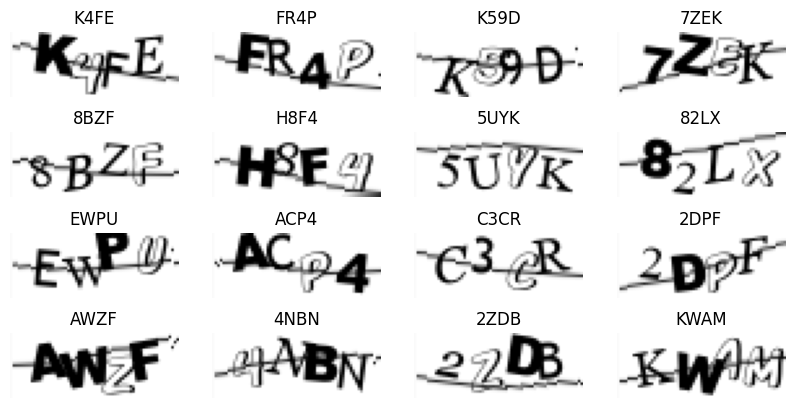

In [9]:
# Visualizing some training data
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in dataset_train.take(1):
    dir_img = batch["image"]
    img_labels = batch["label"]
    for i in range(16):
        img = (dir_img[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(img_labels[i])).numpy().decode("utf-8")
        label = label.replace('[UNK]', '')  # Replace '[UNK]' with an empty string
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [10]:
# CTC loss calculation
class LayerCTC(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost


    def call(self, y_true, y_pred):
        batch_len = tf.shape(y_true)[0]
        input_length = tf.fill([batch_len, 1], img_width // downsample_factor)
        label_length = tf.shape(y_true)[1]
        # Compute the training-time loss value
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")


        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")


        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)


        # Return Computed predictions
        return y_pred

In [11]:
import tensorflow as tf
from keras import backend as K
import gc

# Clear Keras session
K.clear_session()

# Reset TensorFlow graph
tf.compat.v1.reset_default_graph()

# Garbage collection to free up memory
gc.collect()

# Managing GPU memory for TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error in setting memory growth for GPU:", e)

# Print statement to confirm execution
print("Cleared Keras session, reset TensorFlow graph, and managed GPU memory.")


def model_build(dropout_rate):
    # Define the inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    img_labels = layers.Input(name="label", shape=(None,), dtype="float32")


    # First convolutional block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.BatchNormalization(name="batch_norm1")(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    # Second convolutional block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.BatchNormalization(name="batch_norm2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Reshaping the output before passing to RNN
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(dropout_rate)(x)

    #RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    #Calculate CTC loss at each step
    output = LayerCTC(name="ctc_loss")(img_labels, x)

    # Defining the model
    model = keras.models.Model(
        inputs=[input_img, img_labels], outputs=output, name="ocr_model_v1"
    )
    # opt = keras.optimizers.Adam()

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9)
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model
    model.compile(optimizer=opt)


def model_build_v2(dropout_rate):
    # Define the inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    img_labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First convolutional block
    x = layers.Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.BatchNormalization(name="batch_norm1")(x)
    x = layers.Activation("relu")(x)  # Activation after batch normalization
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second convolutional block
    x = layers.Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.BatchNormalization(name="batch_norm2")(x)
    x = layers.Activation("relu")(x)  # Activation after batch normalization
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Third convolutional block (newly added)
    x = layers.Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same", name="Conv3")(x)
    x = layers.BatchNormalization(name="batch_norm3")(x)
    x = layers.Activation("relu")(x)  # Activation after batch normalization
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)  # Additional max pooling layer

    # Reshaping the output before passing to RNN
    new_shape = ((img_width // 8), (img_height // 8) * 128)  # Adjusted due to additional max pooling
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(dropout_rate)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Calculate CTC loss at each step
    output = LayerCTC(name="ctc_loss")(img_labels, x)

    # Defining the model
    model = keras.models.Model(inputs=[input_img, img_labels], outputs=output, name="ocr_model_v1")

    # Learning rate schedule and optimizer
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model
    model.compile(optimizer=opt)

    return model


# Build the model
model = model_build_v2(0.2)
model.summary()


# Early Stopping Parameters and EPOCH
epochs = 200
early_stopping_patience = 10


early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

lr_scheduler = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * (0.9 ** epoch), verbose=1
)

# Training the model
history = model.fit(
    dataset_train,
    validation_data=val_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
 #   callbacks=[early_stopping, lr_scheduler],    
)


Cleared Keras session, reset TensorFlow graph, and managed GPU memory.


Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 65, 25, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 65, 25,    │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm1         │ (None, 65, 25,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 65, 25,    │          0 │ batch_norm1[0][0] │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 12,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 32, 12,    │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm2         │ (None, 32, 12,    │        256 │ Conv2[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 12,    │          0 │ batch_norm2[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 16, 6, 64) │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv3 (Conv2D)      │ (None, 16, 6,     │     73,856 │ pool2[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm3         │ (None, 16, 6,     │        512 │ Conv3[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 6,     │          0 │ batch_norm3[0][0] │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 8, 3, 128) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 384)    │          0 │ pool3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 8, 64)     │     24,640 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 64)     │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 8, 256)    │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 8, 128)    │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                 

 Total params: 483,933 (1.85 MB)

 Trainable params: 483,485 (1.84 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 244.3755 - val_loss: 222.1053
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 224.7334 - val_loss: 228.6668
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 209.4686 - val_loss: 187.4563
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 185.2377 - val_loss: 230.3545
Epoch 5/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 149.6416 - val_loss: 150.1608
Epoch 6/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 119.2069 - val_loss: 98.9368
Epoch 7/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 95.6606 - val_loss: 91.4026
Epoch 8/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 79.5480 - val_loss: 77.4939
Epoch 9/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 67.1787 - val_loss: 67.6538
Epoch 10/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 58.0916 - val_loss: 50.2823
Epoch 11/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 48.3713 - val_loss: 63.17

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 65, 25, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 65, 25, 32)        320       
                                                                 
 batch_norm1 (BatchNormaliz  (None, 65, 25, 32)        128       
 ation)                                                          
                                                                 
 activation (Activation)     (None, 65, 25, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 12, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 12, 64)        18496     
                                                           

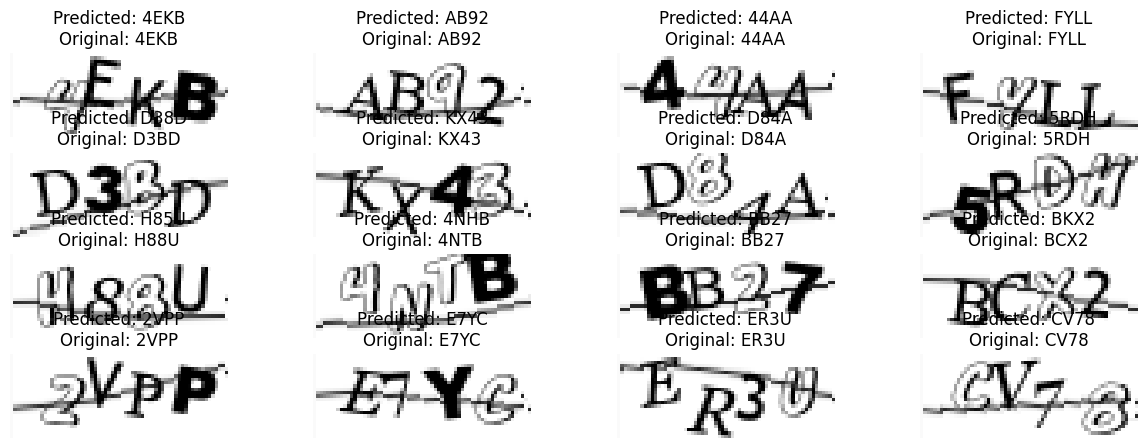

In [17]:
# Get the Model
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]

    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        res = res.replace("[UNK]", "").strip()
        output_text.append(res)
    return output_text

# Check the validation on a few samples
for batch in val_data.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]


    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)


    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8").replace("[UNK]", "").strip()
        orig_texts.append(label)


    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        # Include both the predicted text and the original text in the title
        title = f"Predicted: {pred_texts[i]}\nOriginal: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()



In [18]:
correct_predictions = 0
total_predictions = 0

# Iterate over all batches in the validation dataset
for batch in val_data:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # Get predictions
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    # Get original texts
    orig_texts = [tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8").replace("[UNK]", "").strip()
                  for label in batch_labels]

    # Update accuracy calculations
    correct_predictions += sum(pred == orig for pred, orig in zip(pred_texts, orig_texts))
    total_predictions += len(pred_texts)

# Calculate and print accuracy
accuracy = 100 * correct_predictions / total_predictions if total_predictions > 0 else 0
print(f"Accuracy on Validation Dataset: {accuracy} %")
print(f"Total: {total_predictions}, Correct: {correct_predictions}, Wrong: {total_predictions-correct_predictions}")


1/1 [==============================] - 0s 23ms/step
Accuracy on Validation Dataset: 75.5 %
Total: 200, Correct: 151, Wrong: 49


In [20]:
import tensorflow as tf

# Image dimensions and other constants (from your code)
img_width = 65
img_height = 25

def process_new_image(img_path):
    # Read the image
    img = tf.io.read_file(img_path)
    # Converting the image to grayscale
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resizing to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # Transposing the image
    img = tf.transpose(img, perm=[1, 0, 2])
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load your image
image_path = './captcha_images_8k/2AWY.png'
processed_image = process_new_image(image_path)

# Predict using the model
preds = prediction_model.predict(processed_image)

# Decode the predictions
decoded_preds = decode_batch_predictions(preds)

print(decoded_preds)


1/1 [==============================] - 0s 15ms/step
['2AWY']


In [22]:
import tensorflow as tf
import zipfile
import shutil

# Assuming 'prediction_model' is your TensorFlow model
suffix = f"{accuracy:.2f}"
model_path = 'captcha_model_' + suffix
prediction_model.save(model_path)

prediction_model.save(model_path + ".h5")

# Zip the saved model directory
shutil.make_archive(model_path, 'zip', model_path)

# Unzip the saved model
zip_path = f"{model_path}.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(f"unzipped_model{suffix}")

# Load the model
loaded_model = tf.keras.models.load_model(f"unzipped_model{suffix}")

def process_new_image(img_path):
    # Read the image
    img = tf.io.read_file(img_path)
    # Converting the image to grayscale
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resizing to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # Transposing the image
    img = tf.transpose(img, perm=[1, 0, 2])
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load your image
image_path = './captcha_images_8k/2AWY.png'
processed_image = process_new_image(image_path)

# Predict using the loaded model
preds = loaded_model.predict(processed_image)

# Decode the predictions (assuming you have this function defined)
decoded_preds = decode_batch_predictions(preds)

print(decoded_preds)

INFO:tensorflow:Assets written to: captcha_model_75.50/assets


INFO:tensorflow:Assets written to: captcha_model_75.50/assets


/Users/tenman/captcha-solver/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 521ms/step
['2AWY']
